<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap09/9_3_Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 9.3: Ensembling**

This notebook investigates how ensembling can improve the performance of models. We'll work with the simplified neural network model (figure 8.4 of book) which we can fit in closed form, and so we can eliminate any errors due to not finding the global maximum.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# Define seed to get same results each time
np.random.seed(1)

In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [6]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y)
    return x,y

In [7]:
# Draw the fitted function, together with uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

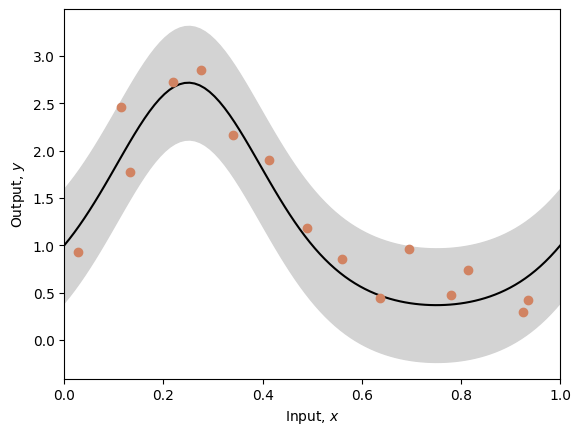

In [8]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the function, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [9]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [10]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          # Compute preactivation
          A[i,j] = x[i]-(j-1)/n_hidden
          # Apply the ReLU function
          if A[i,j] < 0:
              A[i,j] = 0;

  # Add a tiny bit of regularization
  reg_value = 0.00001
  regMat = reg_value * np.identity(n_hidden+1)
  regMat[0,0] = 0

  ATA = np.matmul(np.transpose(A), A) +regMat
  ATAInv = np.linalg.inv(ATA)
  ATAInvAT = np.matmul(ATAInv, np.transpose(A))
  beta_omega = np.matmul(ATAInvAT,y)
  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

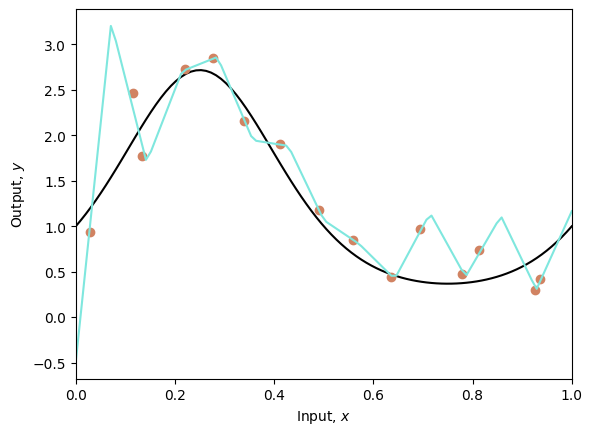

Mean square error = 0.195


In [11]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=14)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model-y_func) * (y_model-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

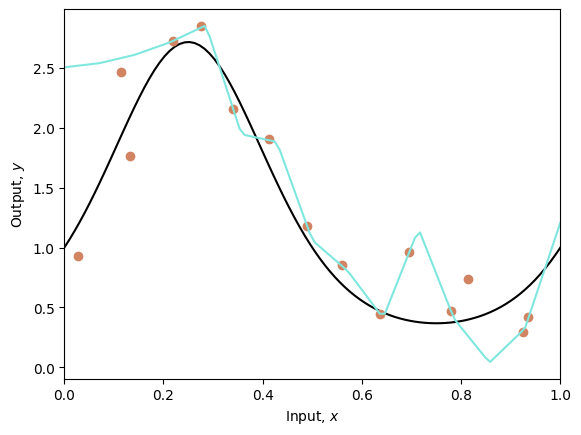

Mean square error = 0.222


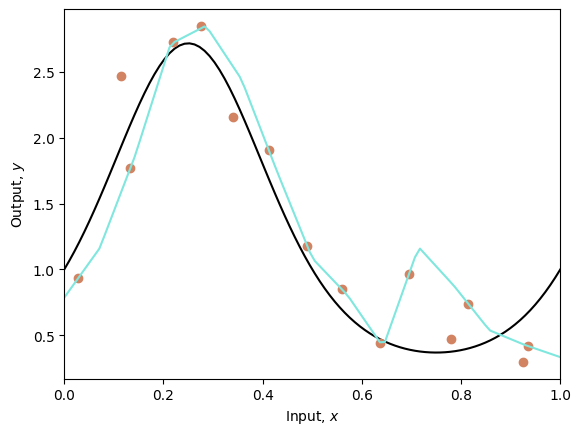

Mean square error = 0.098


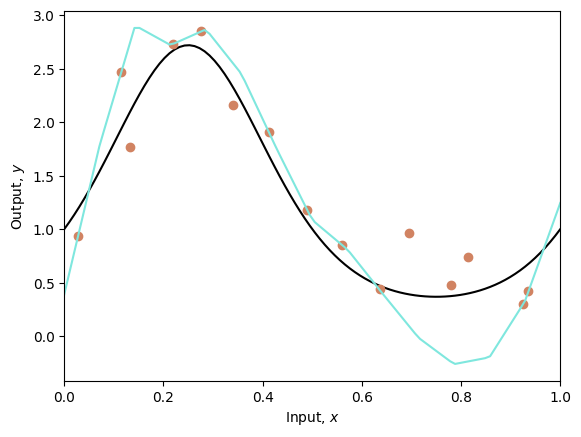

Mean square error = 0.120


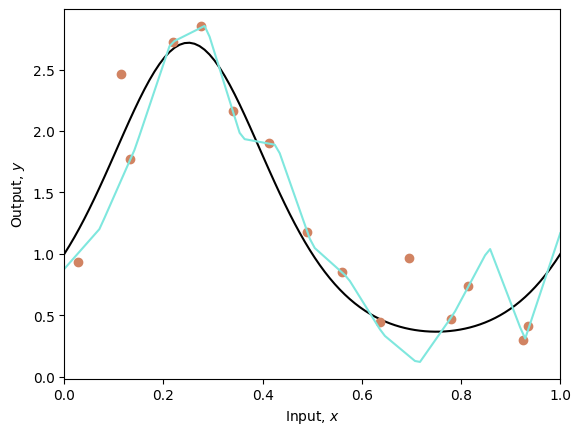

Mean square error = 0.048


In [12]:
# Now let's resample the data with replacement four times.
n_model = 4
# Array to store the prediction from all of our models
all_y_model = np.zeros((n_model, len(y_model)))

# For each model
for c_model in range(n_model):
    # TODO Sample data indices with replacement (use np.random.choice)
    # Replace this line
    resampled_indices = np.random.choice(n_data, size=n_data, replace=True)

    # Extract the resampled x and y data
    x_data_resampled = x_data[resampled_indices]
    y_data_resampled = y_data[resampled_indices]

    # Fit the model
    beta, omega = fit_model_closed_form(x_data_resampled,y_data_resampled,n_hidden=14)

    # Run the model
    y_model_resampled = network(x_model, beta, omega)

    # Store the results
    all_y_model[c_model,:] = y_model_resampled

    # Draw the function and the model
    plot_function(x_func, y_func, x_data,y_data, x_model, y_model_resampled)

    # Compute the mean squared error between the fitted model (cyan) and the true curve (black)
    mean_sq_error = np.mean((y_model_resampled-y_func) * (y_model_resampled-y_func))
    print(f"Mean square error = {mean_sq_error:3.3f}")

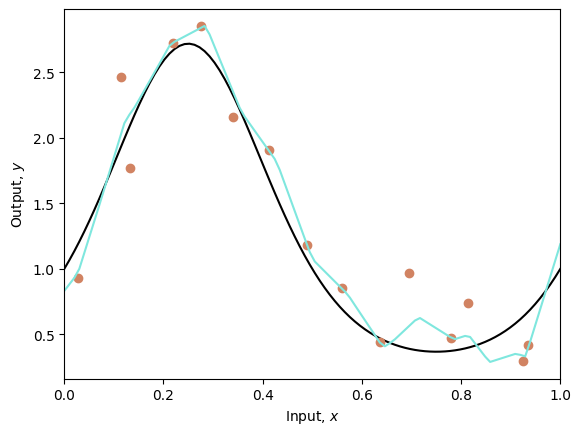

Mean square error = 0.020


In [13]:
# Plot the median of the results
# TODO -- find the median prediction
# Replace this line
y_model_median = np.median(all_y_model, axis=0)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_median)

# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model_median-y_func) * (y_model_median-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

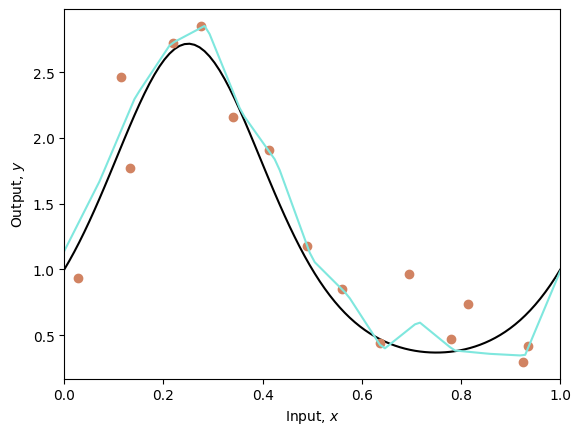

Mean square error = 0.018


In [14]:
# Plot the mean of the results
# TODO -- find the mean prediction
# Replace this line
y_model_mean = np.mean(all_y_model, axis=0)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model_mean)

# Compute the mean squared error between the fitted model (cyan) and the true curve (black)
mean_sq_error = np.mean((y_model_mean-y_func) * (y_model_mean-y_func))
print(f"Mean square error = {mean_sq_error:3.3f}")

You should see that both the median and mean models are better than any of the individual models. We have improved our performance at the cost of four times as much training time, storage, and inference time.